In [63]:
%%capture
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

In [64]:
import os
import numpy as np

from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from tqdm.auto import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

import warnings
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print('The number of GPUs available: {}'.format(torch.cuda.device_count()))
device = "cuda" if torch.cuda.is_available() else "cpu" 

Tesla P100-PCIE-16GB
The number of GPUs available: 1


In [65]:
verts, faces, aux = load_obj('/content/drive/MyDrive/papers/data/source.obj')

In [66]:
faces_idx = faces.verts_idx.to(device) # (F, 3): indexes of each triangular faces' three vertices
# norms_idx = faces.normals_idx.to(device)
# texts_idx = faces.textures_idx.to(device)
# mats_idx = faces.materials_idx.to(device)
verts = verts.to(device) # (V, 3): xyz coordinates of each vertices

In [67]:
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])
src_mesh = ico_sphere(4, device) # unit sphere with 4 iterations of mesh face subdivision

In [68]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


def plot_pointcloud(mesh1, mesh2):
    # Sample points uniformly from the surface of the mesh.
    points1 = sample_points_from_meshes(mesh1, 5000) # (1, 5000, 3)
    x1, y1, z1 = points1.clone().detach().cpu().squeeze().unbind(1) # squeeze => (5000, 3), unbind(1) => (5000) * 3

    points2 = sample_points_from_meshes(mesh2, 5000) # (1, 5000, 3)
    x2, y2, z2 = points2.clone().detach().cpu().squeeze().unbind(1) # squeeze => (5000, 3), unbind(1) => (5000) * 3

    fig = make_subplots(rows=1, cols=2, specs=[[{'is_3d': True}, {'is_3d': True}]])
    fig.add_trace(go.Scatter3d(x=x1, y=y1, z=z1, mode='markers', marker=dict(size=1)), row=1, col=1)
    fig.add_trace(go.Scatter3d(x=x2, y=y2, z=z2, mode='markers', marker=dict(size=1)), row=1, col=2)
   
    camera = dict(eye=dict(x=0, y=0., z=2.5))
    fig.update_layout(height=600, width=800, title_text="Target mesh/Source mesh", scene_camera=camera)
    
    fig.show()

In [69]:
plot_pointcloud(trg_mesh, src_mesh)

In [80]:
src_mesh.verts_list()[0].shape, src_mesh.verts_packed().shape

(torch.Size([2562, 3]), torch.Size([2562, 3]))

In [81]:
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True) # allows gradient update
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [82]:
# Number of optimization steps
Niter = 20000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 2500
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(trg_mesh, new_src_mesh)
        
    # Optimization step
    loss.backward()
    optimizer.step()

Output hidden; open in https://colab.research.google.com to view.

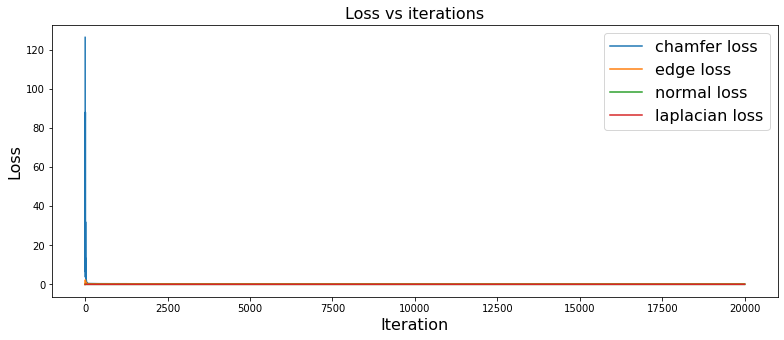

In [83]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [84]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Store the predicted mesh using save_obj
save_obj('/content/drive/MyDrive/papers/data/target.boj', final_verts, final_faces)